# TP 2 - Procesamiento del Lenguaje Natural

## Librerias y Funciones


In [84]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.preprocessing import DenseTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, detect_langs
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import scipy.stats as st
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.layers import Dense, Input, Dropout
from emoji import emoji_count, demojize
import os

In [85]:
def mostrar_scores(y_test: np.ndarray, y_prediccion: np.ndarray):
    accuracy = accuracy_score(y_test,y_prediccion)
    recall = recall_score(y_test,y_prediccion)
    f1 = f1_score(y_test,y_prediccion,)
    precision = precision_score(y_test,y_prediccion)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

def cantidad_de_palabras(review):
    return len(review.split())

## Analisis Exploratorio

In [86]:
df = pd.read_csv('train.csv', sep=',')
df.head(10)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
5,5,Probablemente mi película favorita de todos lo...,positivo
6,6,Seguro que me gustaría ver una resurrección de...,positivo
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo
8,8,Alentados por los comentarios positivos sobre ...,negativo
9,9,"Si te gusta la risa original desgarradora, te ...",positivo


In [87]:
df.shape

(50000, 3)

En primer lugar vamos a analizar el dataset para ver si contiene emojis

In [88]:
df['tiene_emoji'] = df['review_es'].apply(emoji_count)
cantidad_emojis = df['tiene_emoji'].value_counts().reset_index()
cantidad_emojis.columns = ['cantidad_emojis', 'cantidad_filas']
cantidad_emojis

,cantidad_emojis,cantidad_filas
0,0,49995
1,1,5


In [89]:
df.drop(['tiene_emoji'], axis=1, inplace=True)

In [90]:
df['cantidad_de_palabras'] = df['review_es'].apply(cantidad_de_palabras)

In [91]:
df['cantidad_de_palabras'].describe()

count    50000.000000
mean       237.233680
std        179.529306
min          6.000000
25%        123.000000
50%        172.000000
75%        293.000000
max       2450.000000
Name: cantidad_de_palabras, dtype: float64

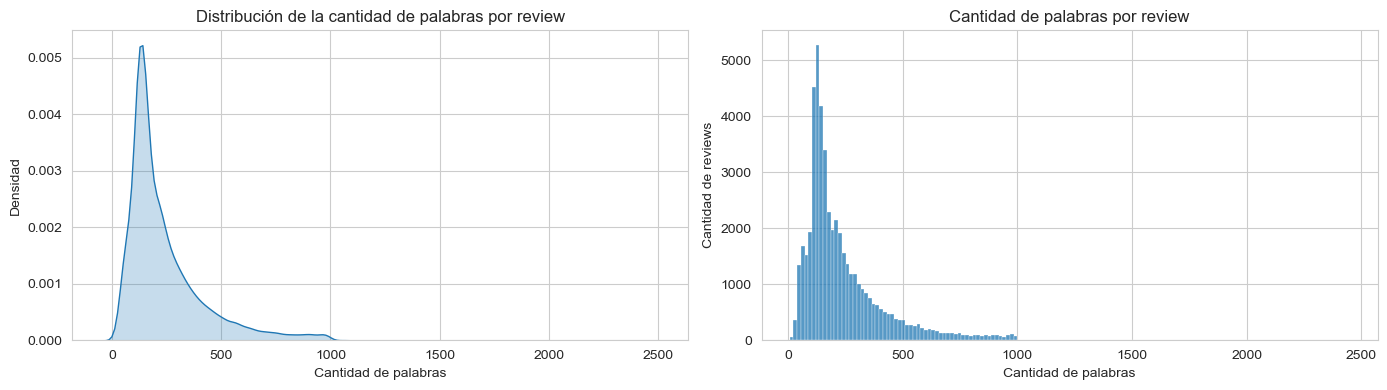

In [62]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.kdeplot(df['cantidad_de_palabras'], fill=True, ax=ax1).set_title('Distribución de la cantidad de palabras por review')
ax1.set_ylabel('Densidad')
ax1.set_xlabel('Cantidad de palabras')

sns.histplot(df['cantidad_de_palabras'],  ax=ax2, bins=150, kde=False).set_title('Distribución de la cantidad de palabras por review')
ax2.xlabel('Cantidad de palabras')
ax2.ylabel('Cantidad de reviews')

plt.title('Cantidad de palabras por review')
plt.tight_layout()
plt.show()

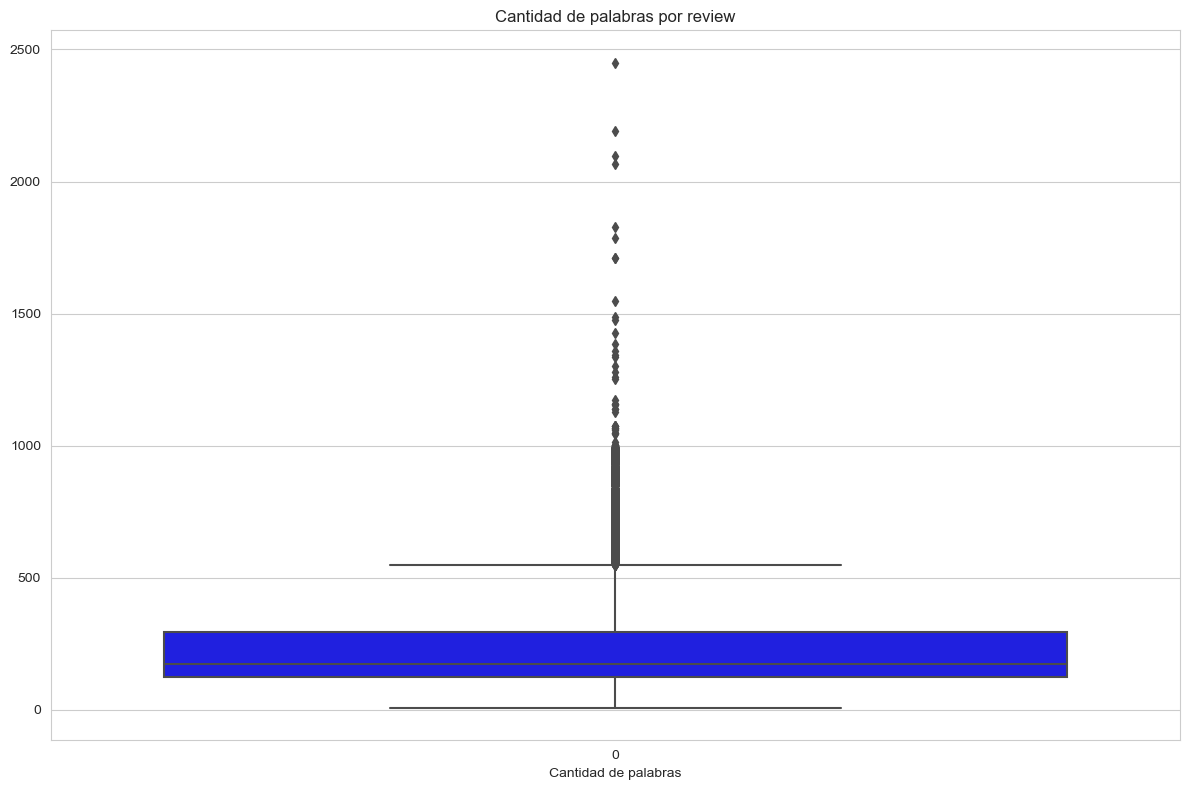

In [44]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.boxplot(df['cantidad_de_palabras'], color='blue')
plt.xlabel('Cantidad de palabras')
plt.title('Cantidad de palabras por review')
plt.tight_layout()
plt.show()

In [92]:
df['zscore'] = (df['cantidad_de_palabras'] - df['cantidad_de_palabras'].mean()) / df['cantidad_de_palabras'].std()

In [93]:
df_z_score = df[(df['zscore'] > 3) | (df['zscore'] < -3)]
df_z_score.shape

(1240, 5)

In [94]:
mediana_cantidad_de_palabras=np.median(df['cantidad_de_palabras'])
MAD=np.median(np.absolute(df['cantidad_de_palabras']-mediana_cantidad_de_palabras))

df['zm_cantidad_de_palabras']=(df['cantidad_de_palabras'] - mediana_cantidad_de_palabras)*0.6745/MAD
df[np.absolute(df['zm_cantidad_de_palabras'] > 3.5)].shape

(4320, 6)

In [95]:
df['review_es'].duplicated().sum()

401

In [100]:
df['idioma'] = df['review_es'].apply(detect)
df['idioma'].value_counts()

es    47783
en     1814
fr        1
id        1
Name: idioma, dtype: int64

In [96]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['review_es'])

vocabulario = vectorizer.get_feature_names_out()

numero_de_palabras_unicas = len(vocabulario)

print("Numero de palabras unicas en el dataset pre preprocesamiento:", numero_de_palabras_unicas)

Numero de palabras unicas en el dataset pre preprocesamiento: 175853


In [97]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import pandas as pd
def contar_palabras_unicas(texto):
    palabras = word_tokenize(texto)
    frecuencia_palabras = FreqDist(palabras)
    palabras_unicas = len(frecuencia_palabras)
    return palabras_unicas

texto_completo = " ".join(df['review_es'].astype(str))

cantidad_palabras_unicas = contar_palabras_unicas(texto_completo)

print("Cantidad de palabras únicas en el conjunto de datos:", cantidad_palabras_unicas)

Cantidad de palabras únicas en el conjunto de datos: 329607


## Preprocesamiento

In [98]:
df = df.drop_duplicates(subset=['review_es'])
df.shape

(49599, 6)

In [101]:
df = df[df['idioma'].isin(['es'])]
df['idioma'].value_counts()

es    47783
Name: idioma, dtype: int64

Como pudimos ver anteriormente, a pesar que sean muy pocos vamos a convertirlos a texto

In [102]:
df['review_es'] = df['review_es'].apply(demojize)

/var/folders/pm/lyty8ft16l3dvy_kdh07l4dc0000gn/T/ipykernel_79381/2887564833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_es'] = df['review_es'].apply(demojize)


In [103]:
df['tiene_emoji'] = df['review_es'].apply(emoji_count)
cantidad_emojis = df['tiene_emoji'].value_counts().reset_index()
cantidad_emojis.columns = ['cantidad_emojis', 'cantidad_filas']
cantidad_emojis

/var/folders/pm/lyty8ft16l3dvy_kdh07l4dc0000gn/T/ipykernel_79381/3651782182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tiene_emoji'] = df['review_es'].apply(emoji_count)


,cantidad_emojis,cantidad_filas
0,0,47783


Teniendo los emojis convertidos a texto podemos continuar trabajando con el dataset

In [104]:
df.drop(['tiene_emoji'], axis=1, inplace=True)

/var/folders/pm/lyty8ft16l3dvy_kdh07l4dc0000gn/T/ipykernel_79381/3954416950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['tiene_emoji'], axis=1, inplace=True)


A continuacion, vamos a eliminar todas las reviews que tengan el z-score modificado mayor a 3.5 en modulo. Decidimos tener mas en cuenta este metodo ya que creemos que es mas efectivo que el z-score normal debido a que los outliers distorsionan notablemente esta metrica.

In [105]:
df = df[np.absolute(df['zm_cantidad_de_palabras'] <= 3.5)]
df.shape

(44143, 7)

Con esto, eliminamos casi un 10% de samples del dataset original, entre los duplicados, las reviews que no estaban en castellano y las que tenian un z-score modificado mayor a 3.5 en modulo.

In [14]:
df_preprocesado = df.copy()
#si ya estan descargados los paquetes no es necesario volver a hacerlo.
#nltk.download('stopwords')
#nltk.download('punkt')

stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Zñáéíóúü\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = nltk.stem.SnowballStemmer('spanish')
    stems = [stemmer.stem(token) for token in tokens]
    preprocessed_text = ' '.join(stems)
    return preprocessed_text

df_preprocesado['review_es'] = df_preprocesado['review_es'].apply(preprocess_text)

In [156]:
from nltk.tokenize.toktok import ToktokTokenizer
df_preprocesado = df.copy()

tokenizer = ToktokTokenizer() 
STOPWORDS = set(stopwords.words("spanish"))
stemmer = nltk.stem.SnowballStemmer("spanish")

def limpiar_texto(texto):
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # Convertimos textos a minusculas
    #texto = texto.lower()
    return texto

def filtrar_stopword_digitos(tokens):
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]

def stem_palabras(tokens):
    return [stemmer.stem(token) for token in tokens]

def tokenize(texto):
    text_cleaned = limpiar_texto(texto)
    tokens = [word for word in tokenizer.tokenize(text_cleaned) if len(word) > 1]
    tokens = filtrar_stopword_digitos(tokens)
    stems = stem_palabras(tokens)
    stems = ' '.join(stems)
    return stems

In [157]:
df_preprocesado['review_es'] = df_preprocesado['review_es'].apply(tokenize)

In [ ]:
df_preprocesado['sentimiento'] = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado['review_es'], df_preprocesado['sentimiento'], test_size=0.2, random_state=42)
df_preprocesado

,ID,review_es,sentimiento,cantidad_de_palabras,zscore,zm_cantidad_de_palabras,idioma
0,0,uno critic mencion despues ver sol oz episodi ...,NaN,345,0.600271,1.823258,es
1,1,una pequeñ pequeñ produccion la tecnic filmaci...,NaN,161,-0.424631,-0.115930,es
2,2,pens maner maravill pas tiemp fin seman veran ...,NaN,173,-0.357789,0.010539,es
3,3,basic famili niñ pequeñ jak piens zombi armari...,NaN,137,-0.558314,-0.368867,es
4,4,el amor tiemp pett mattei pelicul visual impre...,NaN,237,-0.001302,0.685039,es
...,...,...,...,...,...,...,...
49995,49995,pens pelicul hiz buen trabaj derech no tan cre...,NaN,170,-0.374500,-0.021078,es
49996,49996,mal parcel mal dialog mal actuacion direccion ...,NaN,105,-0.736558,-0.706117,es
49997,49997,soy catol enseñ escuel primari parroquial monj...,NaN,246,0.048829,0.779891,es
49998,49998,voy ten desacuerd comentari anterior lad malti...,NaN,232,-0.029152,0.632344,es


Con esto podemos observar brevemente como quedan las reviews luego de este preprocesamiento.

In [109]:
df_preprocesado.head(10)

,ID,review_es,sentimiento,cantidad_de_palabras,zscore,zm_cantidad_de_palabras,idioma
0,0,Uno de los otros críticos ha mencionado que de...,1,345,0.600271,1.823258,es
1,1,Una pequeña pequeña producción.La técnica de f...,1,161,-0.424631,-0.115930,es
2,2,Pensé que esta era una manera maravillosa de p...,1,173,-0.357789,0.010539,es
3,3,"Básicamente, hay una familia donde un niño peq...",0,137,-0.558314,-0.368867,es
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",1,237,-0.001302,0.685039,es
5,5,Probablemente mi película favorita de todos lo...,1,123,-0.636295,-0.516414,es
6,6,Seguro que me gustaría ver una resurrección de...,1,157,-0.446911,-0.158086,es
7,7,"Este espectáculo fue una idea increíble, fresc...",0,168,-0.385640,-0.042156,es
8,8,Alentados por los comentarios positivos sobre ...,0,120,-0.653006,-0.548031,es
9,9,"Si te gusta la risa original desgarradora, te ...",1,31,-1.148747,-1.486008,es


In [110]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df_preprocesado['review_es'])

vocabulario = vectorizer.get_feature_names_out()

numero_de_palabras_unicas = len(vocabulario)

print("Numero de palabras unicas en el dataset post preprocesamiento:", numero_de_palabras_unicas)

Numero de palabras unicas en el dataset post preprocesamiento: 134518


In [111]:
texto_completo = " ".join(df_preprocesado['review_es'].astype(str))

cantidad_palabras_unicas = contar_palabras_unicas(texto_completo)

print("Cantidad de palabras únicas en el conjunto de datos:", cantidad_palabras_unicas)

Cantidad de palabras únicas en el conjunto de datos: 265670


In [115]:
df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
x_train, x_test, y_train, y_test = train_test_split(
                                          df_preprocesado['review_es'], df_preprocesado['sentimiento'], 
                                          test_size=0.2, random_state=42)

### Modelos de Bayes Naïve

##### Vamos a probar en primer lugar con un count vectorizer y luego con un tfidf vectorizer par ver con cual obtenemos merjores resultados

In [ ]:
modelo_count = make_pipeline(CountVectorizer(), MultinomialNB())
modelo_tfidf = Pipeline([('tvec', TfidfVectorizer()), ('mnb',MultinomialNB())])

##### Count vectorizer

In [ ]:
modelo_count.fit(x_train, y_train)

prediccion = modelo_count.predict(x_test)

# mostrar_scores(y_test, prediccion)

In [ ]:
modelo_tfidf.fit(x_train, y_train)

prediccion = modelo_tfidf.predict(x_test)

# mostrar_scores(y_test, prediccion)

In [15]:
df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)


vectorizer = TfidfVectorizer(max_features=9000)
modelo_tfidf = make_pipeline(vectorizer, MultinomialNB(alpha=0.5))
modelo_tfidf.fit(X_train, y_train)

prediccion = modelo_tfidf.predict(X_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8244623655913978
Recall: 0.8371905274488698
Precision: 0.8161070304302204
f1 score: 0.8265143464399575


In [16]:
prediccion_train = modelo_tfidf.predict(X_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8508597597857082
Recall: 0.8575684656812192
Precision: 0.8475651189127973
f1 score: 0.8525374494503617


In [ ]:
df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)


vectorizer = TfidfVectorizer(max_features=7000)
modelo_gauss = make_pipeline(vectorizer,   DenseTransformer() ,GaussianNB())
modelo_gauss.fit(X_train, y_train)

prediccion = modelo_gauss.predict(X_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.7362231182795699
Recall: 0.6990043057050592
Precision: 0.7547580996658434
f1 score: 0.7258120852252882


In [ ]:
prediccion_train = modelo_gauss.predict(X_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8185714285714286
Recall: 0.8056401125725117
Precision: 0.8254575413405519
f1 score: 0.8154284385536564


In [85]:
df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)


vectorizer = TfidfVectorizer(max_features=14700)
modelo_bernoulli = make_pipeline(vectorizer, BernoulliNB(
))
modelo_bernoulli.fit(X_train, y_train)

prediccion = modelo_bernoulli.predict(X_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8344086021505376
Recall: 0.8223896663078579
Precision: 0.8423373759647188
f1 score: 0.8322440087145969


In [87]:
prediccion_train = modelo_bernoulli.predict(X_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.854056856476281
Recall: 0.8377449295290478
Precision: 0.8674141306282257
f1 score: 0.8523214129579435


In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_procesado = df_test.copy()

prediccion = modelo_tfidf.predict(df_test_procesado['review_es'].apply(preprocess_text))
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()


df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('entrega.csv', index=False)

### Regresión Logística

In [149]:
modelo_regresion_logistica = Pipeline([('tfidf', TfidfVectorizer(max_features=5000)), ('lr', LogisticRegression(
    penalty='l2',
    C=0.3,
    solver='liblinear',
    max_iter=100, 
    l1_ratio=None, 
    tol=1e-4 
))])
modelo_regresion_logistica.fit(x_train, y_train)

prediccion = modelo_regresion_logistica.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8739381583418281
Recall: 0.8848904267589389
Precision: 0.8620224719101124
f1 score: 0.8733067729083667


In [150]:
prediccion_train = modelo_regresion_logistica.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8869570142153254
Recall: 0.898302197490205
Precision: 0.877864713389934
f1 score: 0.8879658733722496


In [153]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)

prediccion = modelo_regresion_logistica.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('lr_preproceso_demoji.csv', index=False)

KeyboardInterrupt: 

### XGBoost

In [25]:
df_preprocesado_copy = df_preprocesado.copy()
vectorizer = TfidfVectorizer(max_features=9000)
X = vectorizer.fit_transform(df_preprocesado_copy['review_es'])
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})

X_train, X_test, y_train, y_test = train_test_split(X, df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

modelo_xg_boost = XGBClassifier(
    # learning_rate=0.001,
    n_estimators=500,
    # max_depth=5,
    # min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42
)
modelo_xg_boost.fit(X_train, y_train)

y_pred = modelo_xg_boost.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, modelo_xg_boost.predict(X_train))
print(f'F1_score train: {f1_train}')


KeyboardInterrupt: 

In [ ]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [ ]:
df_preprocesado_copy = df_preprocesado.copy()
vectorizer = TfidfVectorizer(max_features=7000)
X = vectorizer.fit_transform(df_preprocesado_copy['review_es'])
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})

X_train, X_test, y_train, y_test = train_test_split(X, df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

modelo_xg_boost = XGBClassifier(
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42
)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1,  0.3,  0.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': list(np.linspace(0.001, 0.1, 10)),
        'n_estimators': [ 300, 400, 500, 600 ],
        }

folds = 5
n_iter = 75
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
random_search = RandomizedSearchCV(modelo_xg_boost, param_distributions=params, n_iter=n_iter, scoring='f1', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=42 )
# random_search.fit(X_train, y_train)

print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best score:')
print(random_search.best_score_ * 2 - 1)

In [ ]:
y_pred = random_search.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, random_search.predict(X_train))
print(f'F1_score train: {f1_train}')

In [26]:
# colsample_bytree=0.6, gamma=0.1, learning_rate=0.08900000000000001, min_child_weight=10, n_estimators=600, subsample=0.6;, score=0.853
df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)


modelo_xg_boost = Pipeline([
  ('tfidf', TfidfVectorizer(max_features=9000)), 
  ('xgb', XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42,
        colsample_bytree=0.6, 
        subsample=0.6,
        gamma=0.3, 
        max_depth=5,
        learning_rate=0.089, 
        min_child_weight=10, 
        n_estimators=700, 
))])

modelo_xg_boost.fit(X_train, y_train)

y_pred = modelo_xg_boost.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, modelo_xg_boost.predict(X_train))
print(f'F1_score train: {f1_train}')


F1_score: 0.8636243735162227
F1_score train: 0.9279236007120052


#### Predicción en los datos de test

In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()
df_test_copia['review_es'] = df_test_copia['review_es'].apply(preprocess_text)

prediccion = modelo_xg_boost.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('entrega.csv', index=False)

### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

modelo_random_forest = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=7000)), 
    ('rfc', RandomForestClassifier(
            criterion='entropy',
            n_jobs=-1,
            random_state=42,
            max_depth=20,
            min_samples_leaf=50,
            n_estimators=1000,
    ))])

modelo_random_forest.fit(X_train, y_train)

y_pred = modelo_random_forest.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, modelo_random_forest.predict(X_train))
print(f'F1_score train: {f1_train}')

F1_score: 0.8187729350415244
F1_score train: 0.8417005382840822


### Red Neuronal

In [86]:
np.random.seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(812)
os.environ['PYTHONHASHSEED']=str(1)


df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

max_words = 10000
max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

def red_neuronal_recurrente():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 128, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    # layer = Dense(256,name='FC1')(layer)
    # layer = Activation('relu')(layer)
    # layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = tf.keras.Model(inputs=inputs,outputs=layer)
    return model

model_rnn = red_neuronal_recurrente()
model_rnn.summary()
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_rnn.fit(sequences_matrix, y_train, batch_size=128, epochs=10, 
            validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

accr = model_rnn.evaluate(test_sequences_matrix, y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

prediccion = model_rnn.predict(test_sequences_matrix)
prediccion = np.where(prediccion >= 0.5, 1, 0)
mostrar_scores(y_test, prediccion)
prediccion = np.where(prediccion == 1, 'positivo', 'negativo')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 128)         1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 out_layer (Dense)           (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2023-11-15 21:13:40.011933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 21:13:40.014735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 21:13:40.015271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190/190 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.7700

2023-11-15 21:16:44.401087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 21:16:44.401976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 21:16:44.402541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190/190 [==============================] - 210s 1s/step - loss: 0.4712 - accuracy: 0.7700 - val_loss: 0.3429 - val_accuracy: 0.8530
Epoch 2/10
465/465 [==============================] - 58s 126ms/step - loss: 0.3531 - accuracy: 0.8504
Test set
  Loss: 0.353
  Accuracy: 0.850
  1/465 [..............................] - ETA: 7:32

2023-11-15 21:22:02.769788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 21:22:02.770414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 21:22:02.770957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

465/465 [==============================] - 53s 113ms/step
Accuracy: 0.8504032258064517
Recall: 0.8519913885898815
Precision: 0.8490211853043711
f1 score: 0.8505036937541974


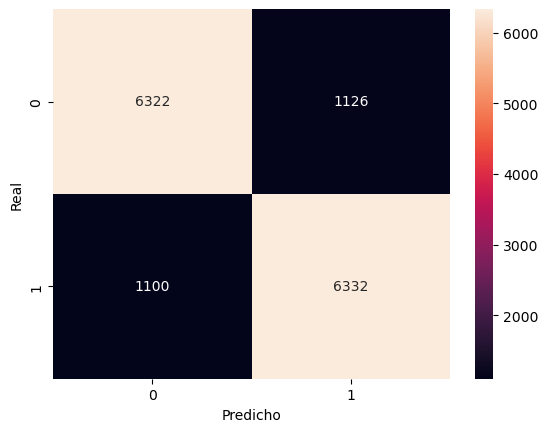

In [88]:
prediccion_heatmap = np.where(prediccion == 'positivo', 1, 0)

tabla = confusion_matrix(y_test, prediccion_heatmap)
sns.heatmap(tabla, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [89]:
train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_train = model_rnn.predict(train_sequences_matrix)
prediccion_train = np.where(prediccion_train >= 0.5, 1, 0)
mostrar_scores(y_train, prediccion_train)

   1/1085 [..............................] - ETA: 4:56

2023-11-15 21:23:10.561498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 21:23:10.561955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 21:23:10.562568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 114s 105ms/step
Accuracy: 0.9131311385696592
Recall: 0.9119399564569726
Precision: 0.9149804552770752
f1 score: 0.9134576757532281


In [92]:
np.random.seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(812)
os.environ['PYTHONHASHSEED']=str(1)

df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
x_train, x_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=sequences_matrix, y=y_train, epochs=10)

# model.evaluate(x=x_test, y=y_test)


Epoch 1/10


2023-11-15 22:15:33.883538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 22:15:33.884783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 22:15:33.885307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 553s 509ms/step - loss: 0.4476 - accuracy: 0.7848
Epoch 2/10
1085/1085 [==============================] - 536s 494ms/step - loss: 0.2515 - accuracy: 0.8988
Epoch 3/10
1085/1085 [==============================] - 531s 489ms/step - loss: 0.1804 - accuracy: 0.9318
Epoch 4/10
1085/1085 [==============================] - 533s 491ms/step - loss: 0.1094 - accuracy: 0.9612
Epoch 5/10
1085/1085 [==============================] - 539s 497ms/step - loss: 0.0599 - accuracy: 0.9803
Epoch 6/10
1085/1085 [==============================] - 553s 509ms/step - loss: 0.0414 - accuracy: 0.9860
Epoch 7/10
1085/1085 [==============================] - 540s 498ms/step - loss: 0.0246 - accuracy: 0.9921
Epoch 8/10
1085/1085 [==============================] - 539s 497ms/step - loss: 0.0200 - accuracy: 0.9933
Epoch 9/10
1085/1085 [==============================] - 536s 494ms/step - loss: 0.0201 - accuracy: 0.9929
Epoch 10/10
1085/1085 [==============================] - 

In [95]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=1000)
prediccion = model.predict(test_sequences_matrix)
prediccion = np.where(prediccion >= 0.5, 1, 0)
mostrar_scores(y_test, prediccion)
prediccion = np.where(prediccion == 1, 'positivo', 'negativo')

465/465 [==============================] - 53s 113ms/step
Accuracy: 0.8436155913978495
Recall: 0.8690796555435952
Precision: 0.8266990912581594
f1 score: 0.8473597900951131


In [97]:
train_sequences = tok.texts_to_sequences(x_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_train = model.predict(train_sequences_matrix)
prediccion_train = np.where(prediccion_train >= 0.5, 1, 0)
mostrar_scores(y_train, prediccion_train)

2023-11-15 23:53:15.747490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 23:53:15.748132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 23:53:15.748825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 126s 115ms/step
Accuracy: 0.9976669834960684
Recall: 0.999427065429128
Precision: 0.9959463317156723
f1 score: 0.997683662672653


### SVM

In [100]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

modelo_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=14500)), 
    ('svm', SVC(C=0.1, random_state=42, gamma='auto', kernel='poly', degree=3))
    ])

modelo_svm.fit(X_train, y_train)

y_pred = modelo_svm.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, modelo_svm.predict(X_train))
print(f'F1_score train: {f1_train}')

F1_score: 0.6661885980638221
F1_score train: 0.6690817089299063


### Ensamble de modelos

In [48]:
display(df_preprocesado_copy)

,ID,review_es,sentimiento
0,0,críticos mencionado después ver solo oz episod...,1
1,1,pequeña pequeña producciónla técnica filmación...,1
2,2,pensé manera maravillosa pasar tiempo fin sema...,1
3,3,básicamente familia niño pequeño jake piensa z...,0
4,4,amor tiempo petter mattei película visualmente...,1
...,...,...,...
49995,49995,pensé película hizo buen trabajo derechano tan...,1
49996,49996,mala parcela mal diálogo mala actuación direcc...,0
49997,49997,católica enseñada escuelas primarias parroquia...,0
49998,49998,voy tener desacuerdo comentario anterior lado ...,0


In [29]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

estimators = [('xgb', modelo_xg_boost), ('lr', modelo_regresion_logistica), ('mnb', modelo_tfidf)]
ensamble = VotingClassifier(estimators=estimators, voting='soft')
ensamble.fit(X_train, y_train)

prediccion = ensamble.predict(X_test)
mostrar_scores(y_test, prediccion)

Accuracy: 0.874260752688172
Recall: 0.8969321851453176
Precision: 0.8578046583451293
f1 score: 0.8769321844372822


In [30]:
prediccion_train = ensamble.predict(X_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.9159538005126876
Recall: 0.9333677094075856
Precision: 0.902748531530533
f1 score: 0.9178028169014084


#### Prediccion en los datos de test

In [31]:
df_test = pd.read_csv('test.csv', sep=',')
df_test

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


In [34]:
df_test_copia = df_test.copy()
df_test_copia['review_es'] = df_test_copia['review_es'].apply(preprocess_text)

train_sequences = tok.texts_to_sequences(df_test_copia['review_es'])
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_final = model.predict(train_sequences_matrix)
prediccion_final = np.where(prediccion_final >= 0.5, 1, 0)


prediccion_final = np.where(prediccion_final == 0, 'negativo', 'positivo')


df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion_final
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('rnr_conv.csv', index=False)

### Red Neuronal Recurrente

In [ ]:
df_copia = df.copy()
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(df_copia['review_es'], df_copia['sentimiento'], test_size=0.3, random_state=42)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, lower = True)
tokenizer.fit_on_texts(x_train)

vocabulario = tokenizer.word_index+1



In [20]:
from collections import Counter

df_preprocesado_copy = df.copy()
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((train_df['review_es'].values, train_df['sentimiento'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['review_es'].values, test_df['sentimiento'].values))

def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

vocabulary = Counter()
for X_batch, y_batch in train_dataset.batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))


2023-11-28 21:03:22.954805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [39679]
	 [[{{node Placeholder/_1}}]]


In [21]:
vocab_size = 10000
truncated_vocabulary = [
 word for word, count in vocabulario.most_common()[:vocab_size]]

In [24]:
words = tf.constant(truncated_vocabulary, dtype=tf.int64)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [27]:
def encode_words(X_batch, y_batch):
    X_batch_int64 = tf.strings.to_number(X_batch, out_type=tf.int64)
    return table.lookup(X_batch_int64), y_batch
train_set = train_dataset.batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [30]:
train_set = train_set.map(lambda x, y: (tf.strings.as_string(x), y))


train_set = train_set.map(lambda x, y: (x, tf.cast(y, tf.float32)))
embed_size = 128
model = keras.models.Sequential([
 keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
 input_shape=[None]),
 keras.layers.GRU(128, return_sequences=True),
 keras.layers.GRU(128),
 keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
 metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

2023-11-28 21:14:37.514105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-28 21:14:37.519931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-28 21:14:37.525235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

UnimplementedError: {{function_node __wrapped__MakeIterator_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cast string to float is not supported
	 [[{{node Cast}}]] [Op:MakeIterator]

In [32]:
import re
import nltk
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
batch_size = 32
epochs = 4
max_len = 25

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

def clean_text(text):
    text = re.sub(r'https?://\S+|www.\S+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in set(nltk.corpus.stopwords.words('english'))]
    text = ' '.join(text)
    return text

train_df['review_es'] = train_df['review_es'].apply(lambda x: clean_text(x))
x_train, y_train = train_df.iloc[:, 3].values, train_df.iloc[:, 4].values

tokenizer = Tokenizer(num_words=vocab_size)

tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
x_train_new = pad_sequences(sequences, maxlen=max_len)

model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = 'RMSprop', metrics=['accuracy'])

model.fit(x_train_new, y_train, batch_size=batch_size, epochs=epochs, verbose = 1)

IndexError: single positional indexer is out-of-bounds

In [ ]:
prediccion = model.predict(x_train_new)
prediccion = np.where(prediccion >= 0.5, 1, 0)
mostrar_scores(y_test, prediccion)
prediccion = np.where(prediccion == 1, 'positivo', 'negativo')

In [12]:
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer() 
STOPWORDS = set(stopwords.words("spanish"))
stemmer = nltk.stem.SnowballStemmer("spanish")

def limpiar_texto(texto):
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # Convertimos textos a minusculas
    texto = texto.lower()
    return texto

def filtrar_stopword_digitos(tokens):
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]

def stem_palabras(tokens):
    return [stemmer.stem(token) for token in tokens]

def tokenize(texto):
    text_cleaned = limpiar_texto(texto)
    tokens = [word for word in tokenizer.tokenize(text_cleaned) if len(word) > 1]
    tokens = filtrar_stopword_digitos(tokens)
    stems = stem_palabras(tokens)
    return stems

# df_preprocesado_copy = df.copy()
# df_preprocesado_copy['review_es'] = df_preprocesado_copy['review_es'].apply(tokenize)

# df_preprocesado_copy['review_es'] = df_preprocesado_copy['review_es'].apply(lambda x: ' '.join(x))

# df_preprocesado_copy.head(10)


In [14]:
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.2, random_state=42)
df_preprocesado_copy

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,1
1,1,Una pequeña pequeña producción.La técnica de f...,1
2,2,Pensé que esta era una manera maravillosa de p...,1
3,3,"Básicamente, hay una familia donde un niño peq...",0
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",1
...,...,...,...
49995,49995,Pensé que esta película hizo un buen trabajo a...,1
49996,49996,"Mala parcela, mal diálogo, mala actuación, dir...",0
49997,49997,Soy católica enseñada en escuelas primarias pa...,0
49998,49998,Voy a tener que estar en desacuerdo con el com...,0


In [21]:
modelo_xg_boost = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)), 
    ('xgb', XGBClassifier(
            objective='binary:logistic',
            n_jobs=-1,
            random_state=42,
            colsample_bytree=0.6, 
            subsample=0.6,
            gamma=0.3, 
            max_depth=5,
            learning_rate=0.089, 
            min_child_weight=10, 
            n_estimators=700, 
    ))])

modelo_xg_boost.fit(X_train, y_train)

y_pred = modelo_xg_boost.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, modelo_xg_boost.predict(X_train))
print(f'F1_score train: {f1_train}')

/home/mateov/programas/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


F1_score: 0.8666208656394151
F1_score train: 0.9194526242854668


In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

modelo = Pipeline([('tfidf', TfidfVectorizer(max_features=5000)), ('mnb',MultinomialNB(alpha=0.5))])
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, modelo.predict(X_train))
print(f'F1_score train: {f1_train}')

F1_score: 0.8363066065477358
F1_score train: 0.8448664864998885


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

modelo = Pipeline([('tfidf', TfidfVectorizer(max_features=5000)), ('lr', LogisticRegression(
    penalty='l2',
    C=10,
    solver='liblinear',
    max_iter=100, 
    l1_ratio=None, 
    tol=1e-4
))])
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, modelo.predict(X_train))
print(f'F1_score train: {f1_train}')


F1_score: 0.8763557483731019
F1_score train: 0.9142376929541333


In [48]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(lambda x: ' '.join(x))
prediccion_final = modelo.predict(df_test_copia['review_es'])
prediccion_final = np.where(prediccion_final == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion_final
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('voting.csv', index=False)

In [15]:
df_copia

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
...,...,...,...
49995,49995,Pensé que esta película hizo un buen trabajo a...,positivo
49996,49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
49997,49997,Soy católica enseñada en escuelas primarias pa...,negativo
49998,49998,Voy a tener que estar en desacuerdo con el com...,negativo


In [70]:
from langdetect import detect, detect_langs

df_post = df.copy()
df_post['idioma'] = df_post['review_es'].apply(detect)


In [71]:
df_copia = df_post.copy()

In [80]:
df_copia['idioma'].value_counts()

es    48181
en     1817
Name: idioma, dtype: int64

In [82]:
from deep_translator import GoogleTranslator

def translate_to_spanish(texto, idioma):
    if texto is None:
        return None

    try:
        if idioma == 'en':
            if texto:
                traduccion = GoogleTranslator(source='english', target='spanish').translate(texto)
                return traduccion
            else:
                return texto
        else:
            return texto
    except Exception as error:
        print(f"Error durante la traducción: {error}")
        return texto

In [78]:
df_copia = df_copia[df_copia['idioma'].isin(['en', 'es'])]

In [83]:
for index, row in df_copia.iterrows():
    if row['idioma'] == 'en':
        df_copia.loc[index, 'review_es'] = translate_to_spanish(row['review_es'],'en' )

Error durante la traducción: From the film's first shot - Keira Knightley as Elizabeth Bennet wandering reading through a field at dawn, thus invoking all the clichés cinema has developed to address the phenomenon of the strong-minded rebellious female character in period drama - I knew I was in for something to make me want to kill myselfJoe Wright seemed not only to have not read the book, but to be under the regrettable misapprehension that what he was filming was not in fact Jane Austen's subtle, nuanced comedy of manners conducted through sparkling, delicate social interaction in eighteenth century English drawing-rooms, but a sort of U-certificate Wuthering Heights Thus we were treated to every scene between Elizabeth and Darcy taking place outside for no apparent reason, in inappropriately rugged scenery and often in the pouring rain Not to mention that Jane Austen, and in particular P & P, is not about passion, sexual tension or love It's about different strategies of negotiati

KeyboardInterrupt: 

In [66]:
df_copia = df_copia[df_copia['idioma'].isin(['es'])]

In [30]:
sample = df_copia[df_copia['ID'] == 49833]['review_es'].values[0]

texto_traducido = translate_to_spanish(str(sample), 'en')
print(texto_traducido)


Error durante la traducción: THE SHOP AROUND THE CORNER is one of the sweetest and most feel-good romantic comedies ever made There's just no getting around that, and it's hard to actually put one's feeling for this film into words It's not one of those films that tries too hard, nor does it come up with the oddest possible scenarios to get the two protagonists together in the end In fact, all its charm is innate, contained within the characters and the setting and the plot which is highly believable to boot It's easy to think that such a love story, as beautiful as any other ever told, *could* happen to you a feeling you don't often get from other romantic comedies, however sweet and heart-warming they may be Alfred Kralik (James Stewart) and Clara Novak (Margaret Sullavan) don't have the most auspicious of first meetings when she arrives in the shop (Matuschek & Co) he's been working in for the past nine years, asking for a job They clash from the very beginning, mostly over a cigare

In [26]:
df_copia['idioma'].value_counts()

idioma
es    47784
Name: count, dtype: int64

In [45]:
df_copia['review_es'] = df_copia['review_es'].apply(tokenize)

df_copia['review_es'] = df_copia['review_es'].apply(lambda x: ' '.join(x))

/tmp/ipykernel_129469/1958305492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copia['review_es'] = df_copia['review_es'].apply(tokenize)
/tmp/ipykernel_129469/1958305492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copia['review_es'] = df_copia['review_es'].apply(lambda x: ' '.join(x))


In [63]:
df_preprocesado_copy = df_copia.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})

X_train, X_test, y_train, y_test = train_test_split(
    df_preprocesado_copy['review_es'].astype(str), 
    df_preprocesado_copy['sentimiento'],
    test_size=0.3,
    random_state=42
)

modelo_regresion_logistica = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('lr', LogisticRegression(
        penalty='l2',
        C=0.3,
        solver='lbfgs',
        max_iter=200,
        l1_ratio=None,
        tol=1e-4
    ))
])
modelo_regresion_logistica.fit(X_train, y_train)

prediccion = modelo_regresion_logistica.predict(X_test)
mostrar_scores(y_test, prediccion)

Accuracy: 0.873046875
Recall: 0.8907340217694669
Precision: 0.8602425876010782
f1 score: 0.8752228163992869


In [64]:
prediccion_train = modelo_regresion_logistica.predict(X_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8909351829705812
Recall: 0.9095354523227384
Precision: 0.8774089627797274
f1 score: 0.8931834153197469


In [49]:
df_test_copia['idioma'] = df_test_copia['review_es'].apply(detect)
df_test_copia['idioma'].value_counts()

idioma
es    1433
ca     472
ro      15
en       4
it       2
fr       2
Name: count, dtype: int64

In [65]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)

df_test_copia['review_es'] = df_test_copia['review_es'].apply(lambda x: ' '.join(x))

prediccion = modelo_regresion_logistica.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('lr_upgrade.csv', index=False)